<a href="https://colab.research.google.com/github/ohbseok/helmet_detection_NextlabCollaboration/blob/main/CP2_motorcycle_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글드라이브 colab 마운트
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
# content/gdrive/My\drive/ 경로가 /mydrive와 같도록 심볼릭 링크를 만듭니다
!ln -s /content/gdrive/MyDrive/Colab\ Notebooks/CP2/ /myd # colab note 사이 띄어쓰기 해주기

In [ ]:
%pwd


'/'

In [ ]:
%cd /myd/yolov4

/content/gdrive/MyDrive/Colab Notebooks/CP2/yolov4


In [ ]:
%ls

darknet/  motorcycle_yolov4_models/  training/


In [ ]:
# !git clone https://github.com/AlexeyAB/darknet


In [ ]:
# makefile 수정(OpenCV, GPU 사용 위해)
%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/gdrive/MyDrive/Colab Notebooks/CP2/yolov4/darknet


In [ ]:
# darknet build
!make


chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/gdrive/MyDrive/Colab Notebooks/CP2/yolov4/darknet/cfg
/content/gdrive/MyDrive/Colab Notebooks/CP2/yolov4/darknet


In [ ]:
# run darknet detection on test images
!./darknet detector test \
cfg/obj.data \
cfg/motorcycle.cfg \
motorcycle_best.weights \
-dont_show -ext_output < data/image_list.txt > result2.txt
# -dont_show -ext_output -thresh 0.3 -out results/result3.json < data/image_list.txt



 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   3 route  1 		                           ->  256 x 256 x  64 
   4 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   5 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   6 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   8 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   9 route  8 2 	                           ->  256 x 256 x 128 
  10 conv 

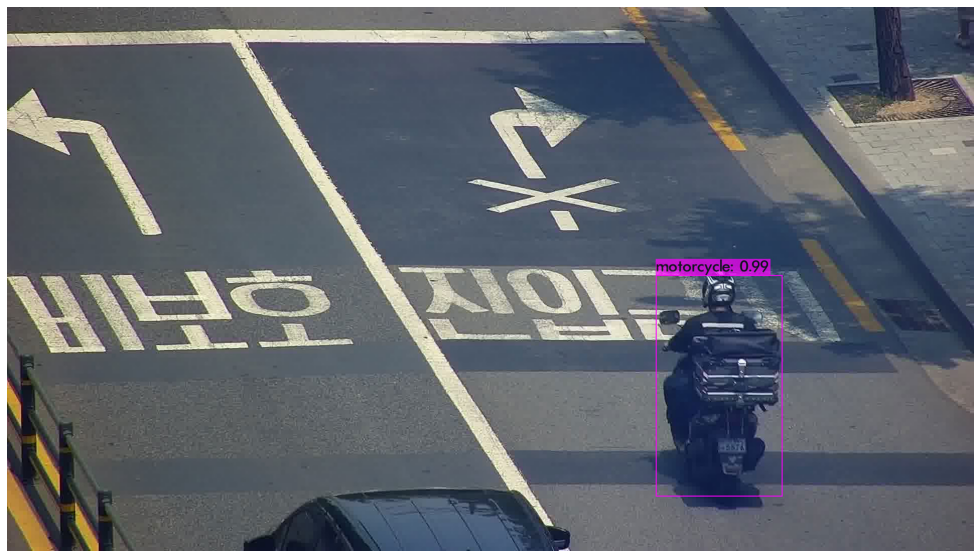

In [ ]:
 imShow('predictions.jpg')

In [ ]:
# box 정보에 대해 margin 값만큼 확장함
def expand_box(box, margin, img_width = None, img_height = None):
    x = box["x"]
    y = box["y"]
    w = box["w"]
    h = box["h"]

    x = x - margin
    x = max(x, 0)
    y = y - margin
    y = max(y, 0)

    w = w + 2*margin
    if img_width and x + w > img_width:
        w = img_width - x

    h = h + 2*margin
    if img_height and y + h > img_height:
        h = img_height - y

    new_box = {
        "x": x, 
        "y": y,
        "w": w,
        "h": h
    }

    return new_box